# Decision Trees

Based on https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/.

<img src="https://av-eks-blogoptimized.s3.amazonaws.com/416511.png" alt="Illustration of a Decision tree" aling="right" style="width: 500px;float: right;"/>

A decision tree is a hierarchical model used in decision support based on conditional control statements. The tree structure is comprised of a root node, branches, internal nodes, and leaf nodes, forming a tree-like structure. These are consituted by

* **Root node**: The initial node at the beginning of a decision tree, where the entire population or dataset starts dividing based on various features or conditions.

* **Decision nodes**: Nodes resulting from the splitting of root nodes are known as decision nodes. These nodes represent intermediate decisions or conditions within the tree.

* **Leaf Nodes/Terminal nodes**: Nodes where further splitting is not possible, often indicating the final classification or outcome.

* **Branch/Sub-tree**: It represents a specific portion of the decision tree and outcomes within the tree.

* **Pruning**: The process of removing or cutting down specific nodes in a decision tree to prevent overfitting and simplify the model.

* **Parent** and **Child node**: In a decision tree, a node that is divided into sub-nodes is known as a parent node, and the sub-nodes emerging from it are called child nodes. The parent node represents a decision or condition, while the child nodes represent the potential outcomes or further decisions based on that condition.

## Overview

In this notebook, we will use a decision tree model for regression of $({\bf X}, {\bf y})$ data to obtain a function $f({\bf x})$ that best models the labels ${\bf y}.$ Then, we will use the analogous methodology but for classification, where we will divide the $({\bf X}, {\bf y})$ data into different categories.

We had previously studied linear regression methods that provide a continuous model $f({\bf x})$. In contrast, a decision trees learns by splitting the training samples in a way such that the sum of squared residuals is minimized. It then predicts the output value by taking the average of all of the examples that fall into a certain leaf on the decision tree and using that as the output prediction.

   
# Libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn                 import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.tree            import DecisionTreeRegressor
from sklearn.tree            import DecisionTreeClassifier
from sklearn.inspection      import DecisionBoundaryDisplay
from sklearn.tree            import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics         import mean_squared_error

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

blue   = '#0021A5'
orange = '#FA4616'

## 1. Information theory

Before training decision tree algorithms it is important that we understand how the method makes choices. We start by realizing that the algorithm must evaluate all variables using some statistical criteria and then choose the variable that performs best on the criteria. Such criterion is applied at each decision node and we typically use one of two methods, namely:
- the entropy and information gain, or
- the Gini index.

Let's beging by discussing entropy and quantifying how much information there exists in a variable. For example, calculating the information for a random variable $X$ with probability distribution $P(X)$ is equivalent to calculating the information for the probability distribution of the events for the random variable. Its value is called **information entropy**, **Shannon entropy**, or simply **entropy**. It is related to the idea of entropy from physics by analogy, in that both are concerned with uncertainty or disorder.

The intuition for entropy is that it is the average number of bits required to represent or transmit an event drawn from the probability distribution for the random variable. In general, the entropy for a random variable $X$ with $k \in K$ discrete states is as follows:
$$
H(X) = - \sum_{k \in K} P(k) \, \log_2 \left[ P(k) \right].
$$
The entropy is the negative of the sum of the probability of each event multiplied by the log of the probability of each event.

---
### Question

**Does the form of the equation remind you of another equation from Materials Science?**

---

This equation for the information entropy is equivalent to the one for the **entropy of mixing for an ideal alloy**:
$$
S_\mathrm{mix} = -k_\mathrm{B}\, \sum_{i=1}^c x_i \ln(x_i)
$$
Here, we use the fractional occupancy of a site in an alloy instead of the probability, which are equivalent.

The difference in the equation for the information entropy is (i) that the `log()` function uses base-2 and (ii) the units are bits instead of J/(mol K).

## Information

The entropy is zero for a random variable that has a single event with a probability of 1.0 or 0.0, a certainty or impossibility. The largest entropy for a random variable occurs when all events are equally likely.

The negative logarithm of the probability, i.e., $-\log_2(\text{probability})$, is referred to as the **self-information** or **surprisal** of an event. It quantifies the amount of "information" gained when that event occurs. **Rarer events are more surprising and, hence, yield higher self-information values.**


We can consider a roll of a fair die and calculate the entropy for the variable. Each outcome has the same probability of 1/6, therefore it is a uniform probability distribution. We therefore would expect the average information to be the same information for a single event. We can further develop the intuition that low probability events have more information.

To make this clear, we can calculate the information for probabilities between 0 and 1 and plot the corresponding information for each. We can then create a plot of probability vs. information. We would expect the plot to curve downward from low probabilities with high information to high probabilities with low information.

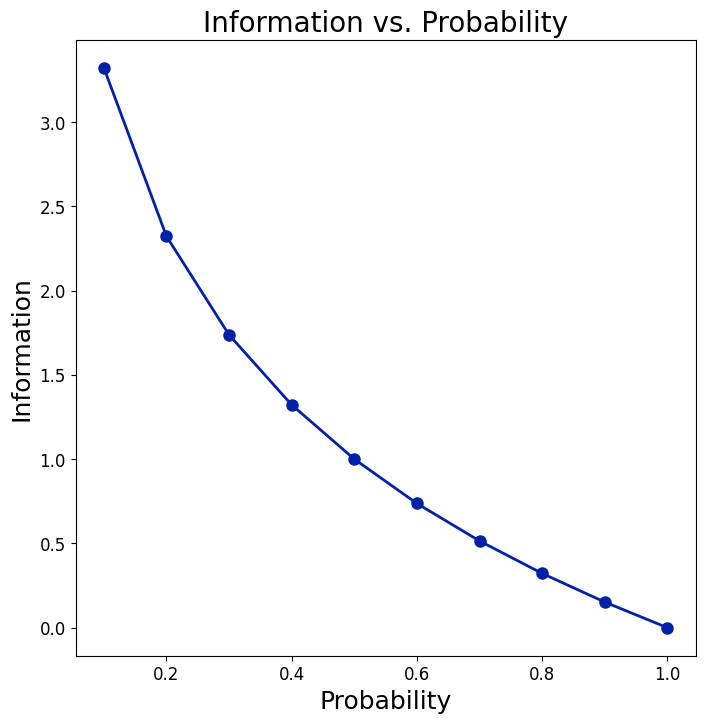

In [2]:
# Compare probability vs. information
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

# List of probabilities
probabilities = np.linspace(0.1, 1.0, num=10)

# Calculate information
information = -np.log2(probabilities)

# Plot probability vs information
plt.figure( figsize=(8, 8) )

plt.plot(probabilities, information, marker='o', c=blue, ms=8, ls='-', lw=2)

plt.title('Information vs. Probability', fontsize=20)

plt.xlabel('Probability', fontsize=18)
plt.ylabel('Information', fontsize=18)

plt.show()

Low probability events are more surprising and carry more information, and the complement of high probability events carry less information. This relationship is not linear, it is in-fact slightly sub-linear because of the use of the log function. 

We can further develop the intuition for entropy of probability distributions. Recall that entropy is the number of bits required to represent a randomly drawn even from the distribution, e.g., an average event. We can explore this for a simple distribution with two events, like a coin flip, but explore different probabilities for these two events and calculate the entropy for each. In the case where one event dominates, such as a skewed probability distribution, then there is less surprise and the distribution will have a lower entropy. In the case where no event dominates another, such as equal or approximately equal probability distribution, then we would expect larger or maximum entropy.

- **Skewed Probability Distribution** (unsurprising): Low entropy.
- **Balanced Probability Distribution** (surprising): High entropy.

If we transition from skewed to equal probability of events in the distribution we would expect entropy to start low and increase, specifically from the lowest entropy of 0.0 for events with impossibility/certainty (probability of 0 and 1 respectively) to the largest entropy of 1.0 for events with equal probability. The example below implements this, creating each probability distribution in this transition, calculating the entropy for each and plotting the result.

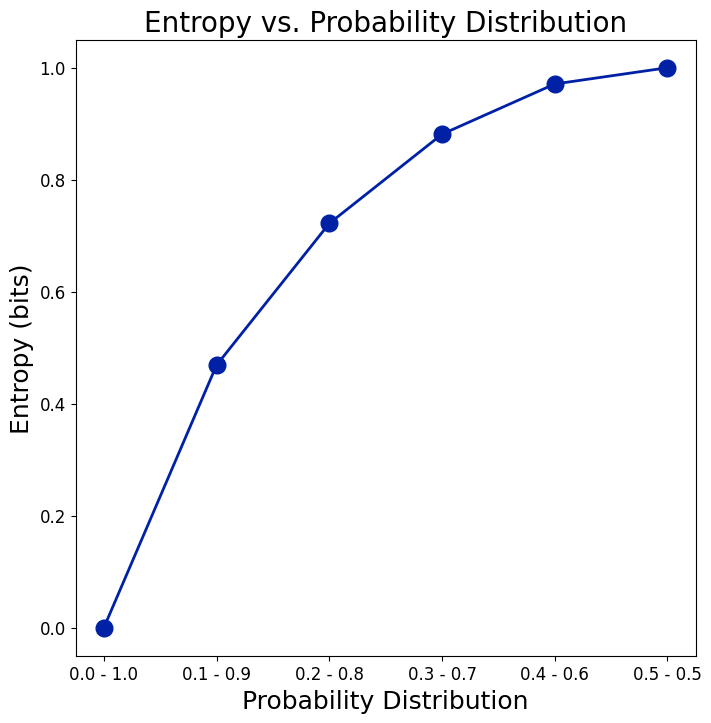

In [3]:
def entropy(events, ets=1e-15):
	return -np.sum( [p * np.log2(p + ets) for p in events] )

# Define probabilities
probabilities = np.linspace(0.0, 0.5, num=6)

# Create probability distribution
distributions = [ [p, 1.0 - p] for p in probabilities ]

# Calculate entropy for each distribution
entropies = [entropy(d) for d in distributions]

plt.figure( figsize=(8, 8) )

plt.plot(probabilities, entropies, marker='o', c=blue, ms=12, ls='-', lw=2)

plt.title('Entropy vs. Probability Distribution', fontsize=20)

plt.xticks(probabilities, [f'{d[0]:.1f} - {d[1]:.1f}' for d in distributions])

plt.xlabel('Probability Distribution', fontsize=18)
plt.ylabel('Entropy (bits)', fontsize=18)

plt.show()

The example creates the 6 probability distributions from [0,1] to [0.5,0.5] probabilities. As expected, we see that as the distribution of events changes from skewed to balanced, the entropy increases from minimal to maximum values. That is, if the average event drawn from a probability distribution is not surprising we get a lower entropy, whereas if it is surprising, we get a larger entropy.

We can see that the transition is not linear, that it is super linear. We can also see that this curve is symmetrical if we continued the transition to [0.6, 0.4] and onward to [1.0, 0.0] for the two events, forming an inverted parabola-shape. Note we had to add a tiny value to the probability when calculating the entropy to avoid calculating the log of a zero value, which would result in an infinity on not a number.

Calculating the entropy for a random variable provides the basis for other measures such as **mutual information** (information gain). Entropy also provides the basis for calculating the difference between two probability distributions with **cross-entropy** and the **KL-divergence**.

## 2. Decision Trees for Regression

We can think of the decision tree learning as a divide and conquer strategy, using a search to identify the optimal split points within a tree. This process of splitting is then repeated in a top-down, recursive manner until all, or the majority of records have been classified. This classification is largely dependent on the complexity of the decision tree. Smaller trees are more easily able to attain pure leaf nodes, i.e., data points in a single class. However, as a tree grows in size, it becomes increasingly difficult to maintain this purity, and it usually results in too little data falling within a given subtree. When this occurs, it is known as data fragmentation, and it can often lead to overfitting. To better illustrate the behavior of decision trees, we will fit a simple one-dimensional function to the same data set that we previously used for linear regression.

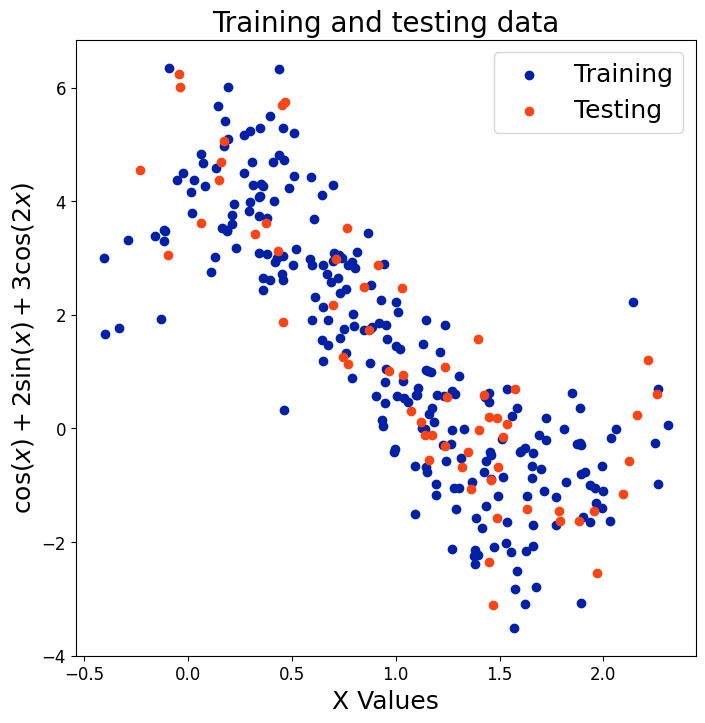

In [4]:
# Create the reference function that generates our data

def reference_function(x):
    return np.cos(x) + 2.0*np.sin(x) + 3.0*np.cos(2.0*x)

np.random.seed(seed=5)

# Generate a data set for machine learning
x = np.linspace(0, 2, 300)
x = x + np.random.normal(0.0, 0.3, x.shape)

y = reference_function(x) + np.random.normal(0.0,1.0, x.shape)

# Split the dataset into 80% for training and 20% for testing
x = x.reshape( (-1,1) )

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=21)

# Plot the training and testing dataset
fig,ax=plt.subplots( figsize=(8,8) )

ax.scatter(X_train, y_train, c=blue, label='Training')
ax.scatter(X_test, y_test,   c=orange, label='Testing')

ax.set_title('Training and testing data',fontsize=20)

ax.set_xlabel('X Values',fontsize=18)
ax.set_ylabel(r'$ \cos(x)+2\sin(x)+3\cos(2x)$',fontsize=18)

plt.legend(loc='best', fontsize=18)

plt.show()

### 2.1 Decision tree model

In [5]:
# Fitting the decision tree regression to the dataset
decision_tree_regression = DecisionTreeRegressor()
decision_tree_regression.fit(X_train, y_train)


y_pred_from_training = decision_tree_regression.predict(X_train)
y_pred_from_testing  = decision_tree_regression.predict(X_test)

training_rmse = np.sqrt( mean_squared_error(y_train, y_pred_from_training) )
testing_rmse  = np.sqrt( mean_squared_error(y_test, y_pred_from_testing) )

# Report results
print(f'Training score = '
      f'{decision_tree_regression.score(X_train,y_train):6.3f} '
      f'with RMSE = {training_rmse:6.3f}')

print(f'Testing  score = '
      f'{decision_tree_regression.score(X_test,y_test):6.3f} '
      f'with RMSE = {testing_rmse:6.3f}')

Training score =  1.000 with RMSE =  0.000
Testing  score =  0.597 with RMSE =  1.456


We get a perfect high score on the training data and a zero RMSE but only a moderately high score on the testing data and a sizable RMSE. This demonstrate extreme overfitting. Let us visualize the model and data to see the results.

Let's have a closer look at our model

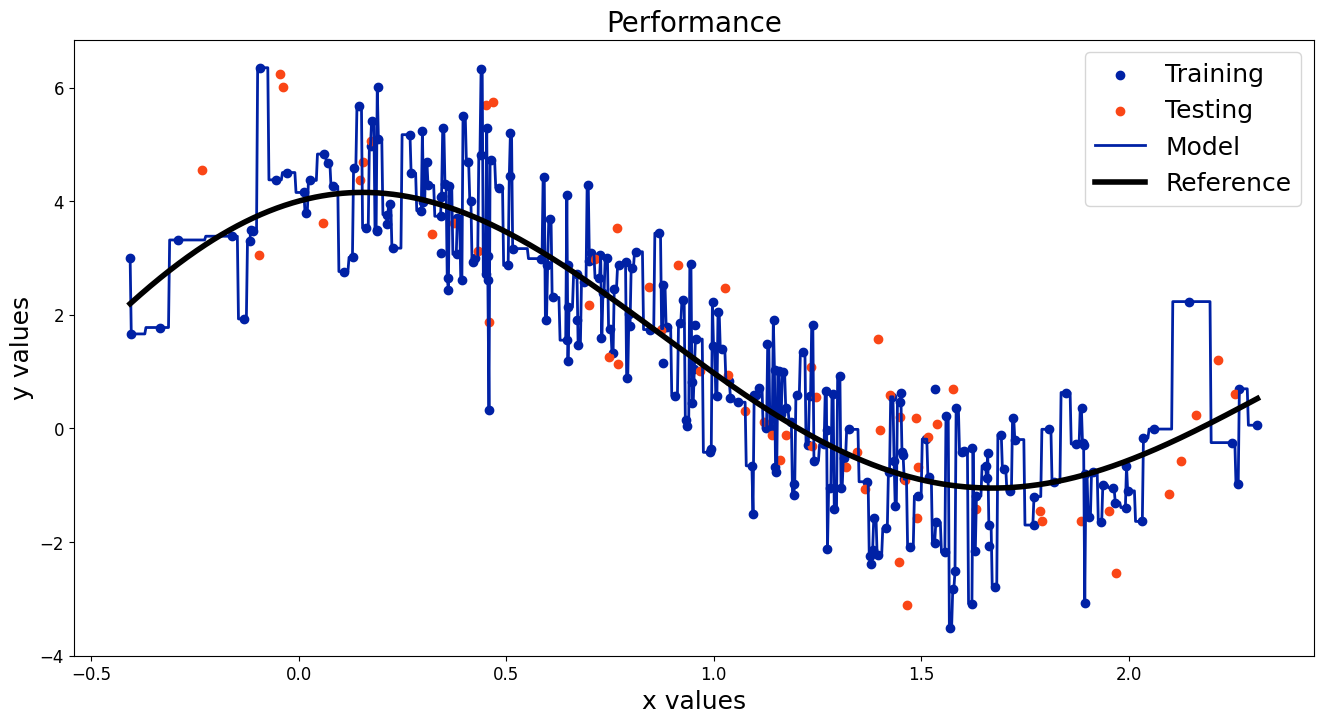

In [6]:
# create a series of sampling points to plot the model
points  = 1000

X_model = np.linspace(np.min(x), np.max(x), num=points)
X_model = X_model.reshape( (-1,1) )

y_model_predictions = decision_tree_regression.predict(X_model)
y_model_reference   = reference_function(X_model)

# Plot the dataset
fig,ax=plt.subplots( figsize=(16,8) )

ax.scatter(X_train, y_train, c=blue, label='Training')
ax.scatter(X_test, y_test, c=orange, label='Testing')

ax.plot(X_model, y_model_predictions, c=blue, lw=2, label='Model')
ax.plot(X_model, y_model_reference,   c='k', lw=4, label='Reference')

ax.set_title('Performance', fontsize=20)

ax.set_xlabel('x values', fontsize=18)
ax.set_ylabel('y values', fontsize=18)

ax.legend(loc='best', fontsize=18)
plt.show()

This plot shows an important issue commonly asssciated with decision tree regression. The resulting model is **piecewise constant**.

We also observe that there is a strong tendency to overfit. In fact,the model has **memorized all the training data**.

Let's check the set of predicted and reference ${\bf y}$ values using a scatter plot.

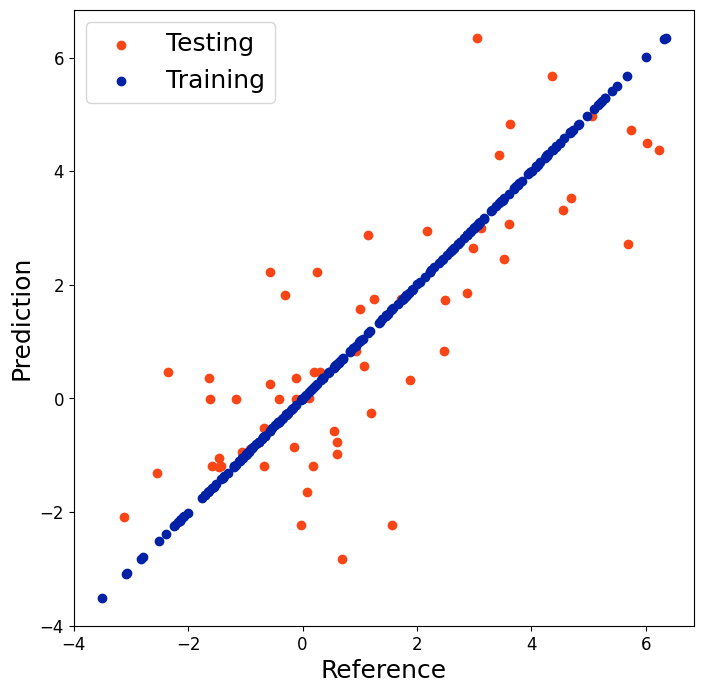

In [7]:
fig,ax=plt.subplots( figsize=(8,8) )

ax.scatter(y_test, y_pred_from_testing, c=orange, label='Testing')
ax.scatter(y_train, y_pred_from_training, c=blue, label='Training')

ax.set_xlabel('Reference', fontsize=18)
ax.set_ylabel('Prediction', fontsize=18)

ax.legend(loc='best', fontsize=18)

plt.show()

### 2.2 Hyperparameter Optimization with Cross-Validation

To address this extreme overfitting, we must optimize the hyperparameters in the decision tree regression.

Here are some of the hyperparameters for decision trees:

In [8]:
# List the hyperparameters that can be tuned
for idx, key in enumerate( decision_tree_regression.get_params().keys() ):
    print(f'({idx+1:2d}): {key}')

( 1): ccp_alpha
( 2): criterion
( 3): max_depth
( 4): max_features
( 5): max_leaf_nodes
( 6): min_impurity_decrease
( 7): min_samples_leaf
( 8): min_samples_split
( 9): min_weight_fraction_leaf
(10): monotonic_cst
(11): random_state
(12): splitter



- `criterion` is used to measure the quality of a split. Its value is `'squared_error'`.

- `max_depth` controls the depth of the tree. It does not make any calculations on our training set. The model stops splitting when max_depth is reached. Note that `max_depth` is less flexible compared to `min_impurity_decrease`.

- `min_impurity_decrease`. When the algorithm performs a split, the main goal is to decrease impurity as much as possible. The more the impurity decreases, the more informative power that split gains. As the tree gets deeper, the amount of impurity decrease becomes lower. We can use this to prevent the tree from doing further splits. Its default is zero.

- `min_samples_split` allows control of the tree based on impurity values by setting a threshold on the Gini index. If the algorithm keeps splitting nodes, the model will probably be overfit. 

- `min_samples_leaf` indicates the minimum number of samples required to be at a leaf node.

- `max_leaf_nodes` limits the number of leaf nodes, which grows the tree in best-first fashion until max_leaf_nodes reached. The best split is decided based on impurity decrease.

- `max_features` sets the number of features to consider when looking for the best split. If not specified, the model considers all of the features. There is only 1 feature in our dataset.

In cell [2.1](###-2.1-Decision-tree-model) above, set the hyperparameter:

~~~
decision_tree_regression = DecisionTreeRegressor( hyperparameter = value )
~~~

### 2.3 Grid Search for Optimal Hyperparameters

Instead of optimizing hyperparameters one by one, we will use a grid search for the optimization of some of the hyperparameters of the decision tree model with cross-validation. The optimal values of hyperparameters depend on each other. The grid search varies all the parameters together, which ensures that we obtain a somewhat optimal model.

In [9]:
# Hyperparameters range to explore

parameters = {
    'min_impurity_decrease' : [0, 0.05, 0.1, 0.2],
    'min_samples_split'     : [0.05, 0.1, 0.2],
    'max_depth'             : [2, 3, 4, 5],
    'min_samples_leaf'      : [1, 2, 3, 4, 5],
    'max_leaf_nodes'        : [None, 2, 4, 8, 12]
    }

# Create the grid search object from sklearn
grid_search = GridSearchCV(decision_tree_regression,
                           param_grid=parameters,
                           scoring='neg_mean_squared_error',
                           cv=5, verbose=0)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Optimized hyperparameters 
optimum_parameters = grid_search.best_params_

# Report the optimized hyperparameters
for key in optimum_parameters:
    print(f'{key:21s} = {optimum_parameters[key]}')

max_depth             = 3
max_leaf_nodes        = None
min_impurity_decrease = 0
min_samples_leaf      = 1
min_samples_split     = 0.05


/Users/rhennig/miniconda3/lib/python3.12/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Now that we know the set of hyperparameters that optimize the performance of the decision tree regression, we can use them to train a new model and compare its performance with the previous one.

In [10]:
# Fitting the optimized decision tree regression to the dataset
optimized_decision_tree_regression = DecisionTreeRegressor(**optimum_parameters)
optimized_decision_tree_regression.fit(X_train, y_train)

y_pred_from_training = optimized_decision_tree_regression.predict(X_train)
y_pred_from_testing  = optimized_decision_tree_regression.predict(X_test)

training_rmse = np.sqrt( mean_squared_error(y_train, y_pred_from_training) )
testing_rmse  = np.sqrt( mean_squared_error(y_test, y_pred_from_testing) )
    
# Report results
print(f'Training score = '
      f'{optimized_decision_tree_regression.score(X_train,y_train):6.3f} '
      f'with RMSE = {training_rmse:6.3f}')

print(f'Testing  score = '
      f'{optimized_decision_tree_regression.score(X_test,y_test):6.3f} '
      f'with RMSE = {testing_rmse:6.3f}')

Training score =  0.820 with RMSE =  0.952
Testing  score =  0.780 with RMSE =  1.076


The optimized model does significantly better.
- It predicts similar training and testing errors.
- The testing error is significantly reduced compared to the unoptimized model.

Let's plot our final model

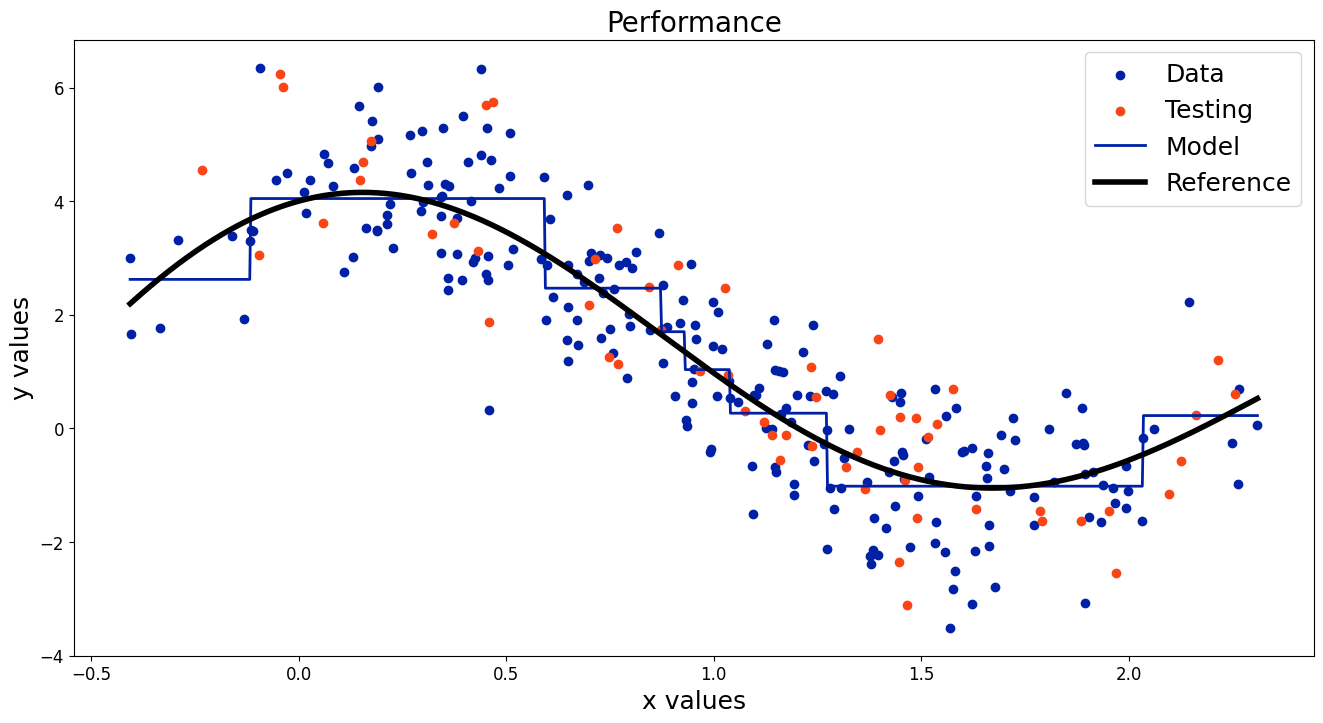

In [11]:
# create a series of sampling points to plot the model
points  = 1000

X_model = np.linspace(np.min(x), np.max(x), num=points)
X_model = X_model.reshape( (-1,1) )

y_model_predictions = optimized_decision_tree_regression.predict(X_model)
y_model_reference   = reference_function(X_model)

# Plot the dataset
fig,ax=plt.subplots( figsize=(16,8) )

ax.scatter(X_train, y_train, c=blue, label='Data')
ax.scatter(X_test, y_test, c=orange, label='Testing')

ax.plot(X_model, y_model_predictions, c=blue, lw=2, label='Model')
ax.plot(X_model, y_model_reference,   c='k', lw=4, label='Reference')

ax.set_title('Performance', fontsize=20)

ax.set_xlabel('x values', fontsize=18)
ax.set_ylabel('y values', fontsize=18)

ax.legend(loc='best', fontsize=18)

plt.show()

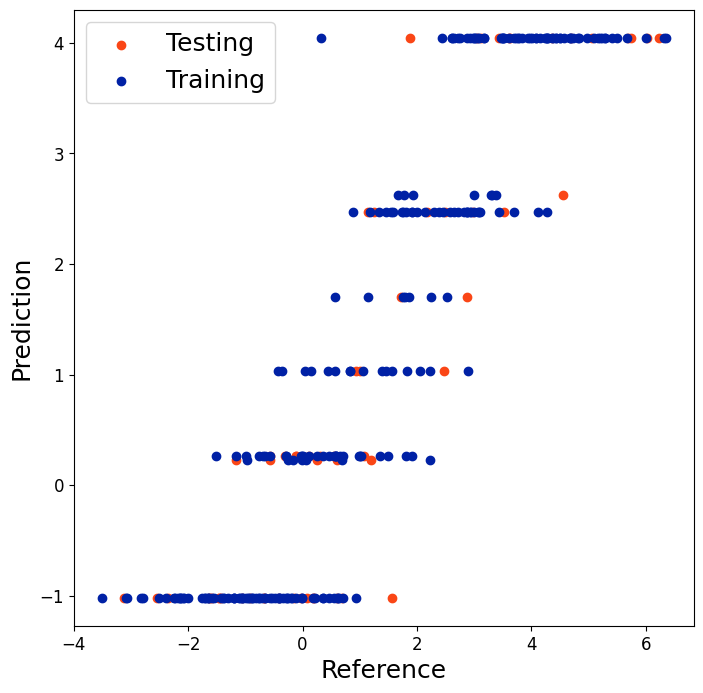

In [12]:
fig,ax=plt.subplots( figsize=(8,8) )

ax.scatter(y_test, y_pred_from_testing, c=orange, label='Testing')
ax.scatter(y_train, y_pred_from_training, c=blue, label='Training')

ax.set_xlabel('Reference', fontsize=18)
ax.set_ylabel('Prediction', fontsize=18)

ax.legend(loc='best', fontsize=18)

plt.show()

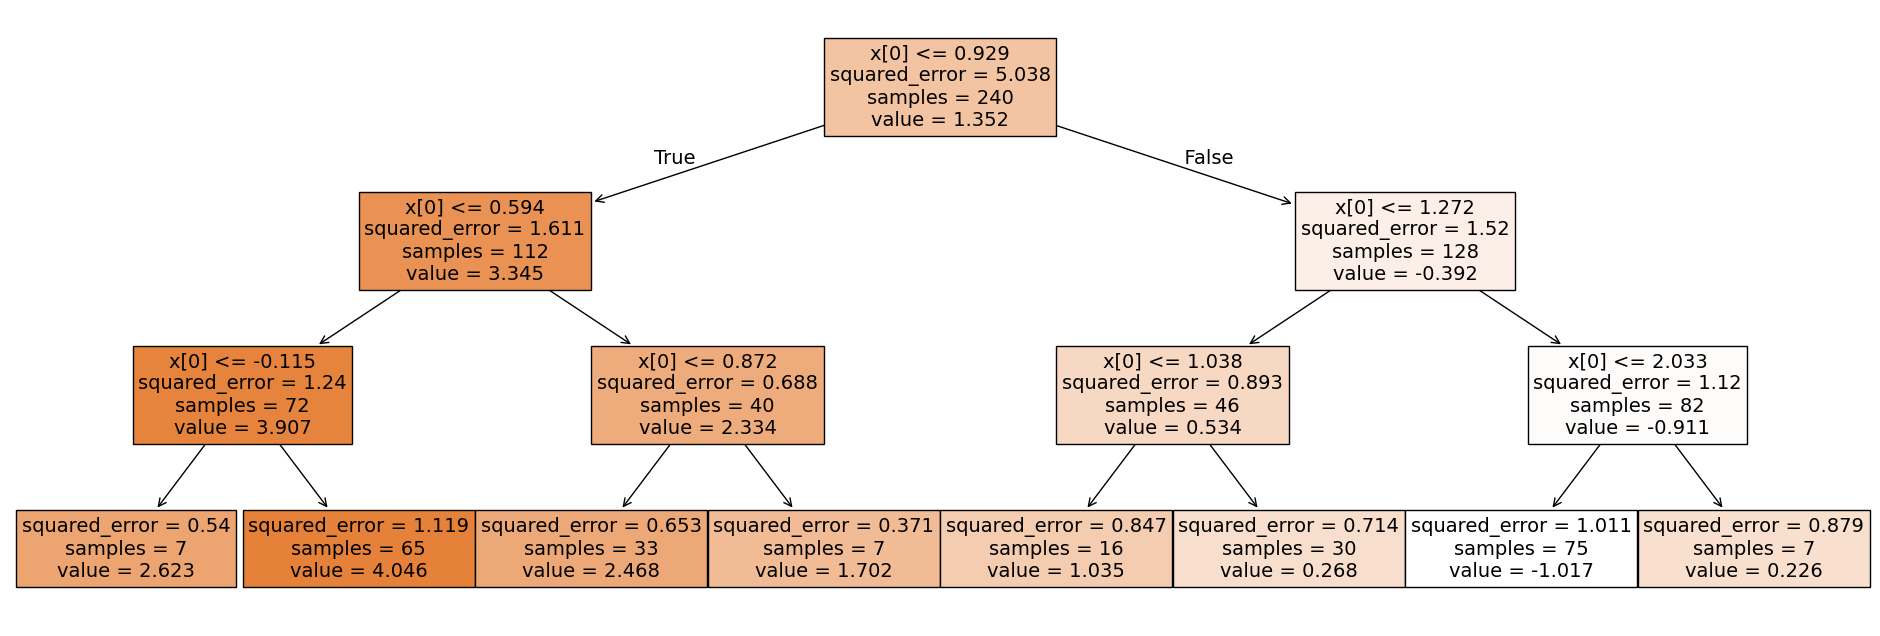

In [13]:
plt.figure(figsize=(24,8))

plot_tree(optimized_decision_tree_regression, filled=True, fontsize=14)

plt.show()

## 3. Decision trees for classification

As already stated, decision trees can also be used to classify our data into different categories. To illustrate this, we will use the same set of insulators, conductors, and semiconductors that we used in the previous chapter. The data is shown in the following figure.

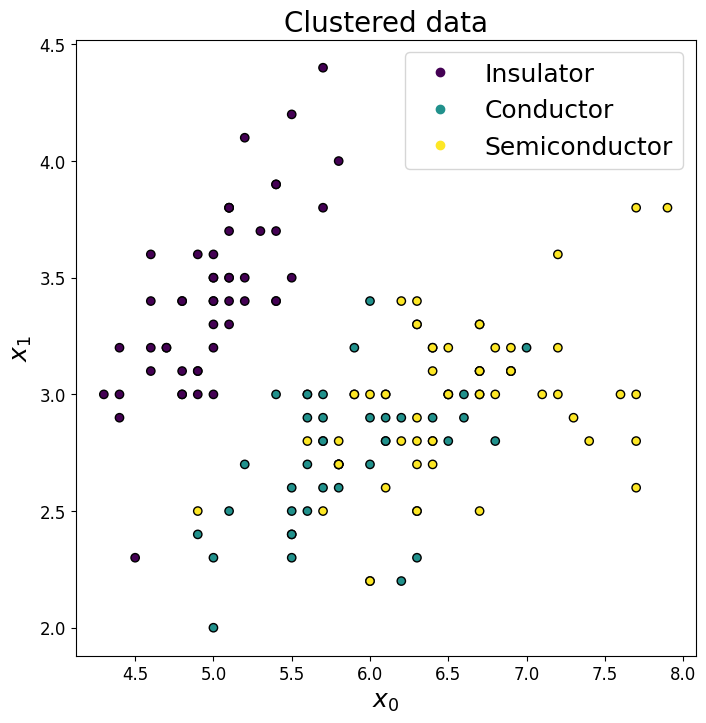

In [14]:
data = datasets.load_iris()

x = data.data[:,:2]
y = data.target

# Plot data

fig, ax = plt.subplots( figsize=(8,8) )

scatter = plt.scatter(x[:,0], x[:,1], c=y, label=y, cmap=plt.cm.viridis, edgecolors='k')

plt.title('Clustered data', fontsize=20)

plt.xlabel(r'$x_0$', fontsize=18)
plt.ylabel(r'$x_1$', fontsize=18)

handles, _ = scatter.legend_elements()

plt.legend(handles=handles, labels=['Insulator', 'Conductor', 'Semiconductor'], loc='best', fontsize=18)

plt.show()

### 3.1 Decision tree model

We often use the so-called Gini index for classification models. It is computed through the set of probabilities $p_i$
$$
C_\mathrm{Gini} = 1 - \sum_{i=1}^n (p_i)^2.
$$

In simple words, this index meassures how often a randomly chosen element would be identified incorrectly. This results in giving preference to attributes with a lower Gini index.

We can now fit a decision tree classifier to the data and visualize the decision boundaries.

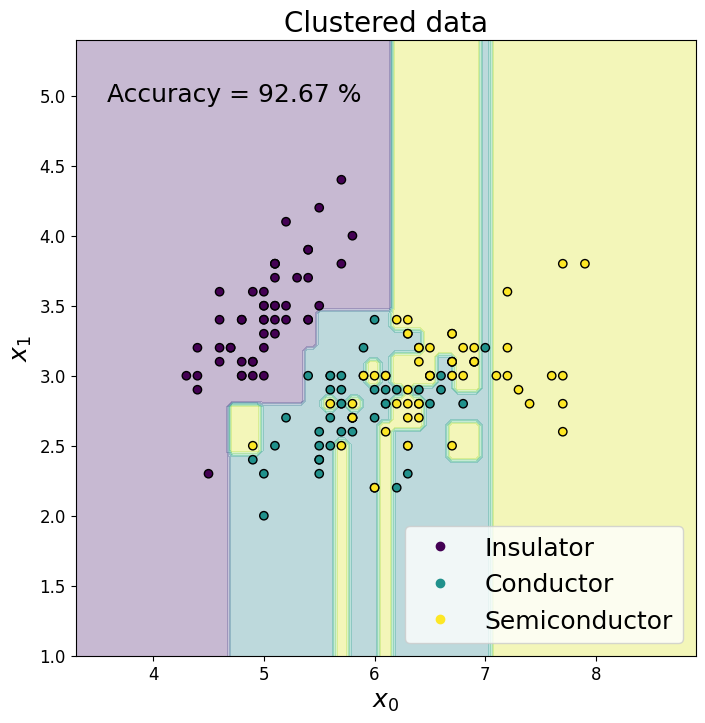

In [15]:
decision_tree_classification = DecisionTreeClassifier()
decision_tree_classification.fit(x, y)

accuracy = decision_tree_classification.score(x, y)

fig, ax = plt.subplots( figsize=(8,8) )

DecisionBoundaryDisplay.from_estimator(decision_tree_classification, x,
                                       ax=ax, cmap=plt.cm.viridis, response_method='predict', alpha=0.3)

scatter = plt.scatter(x[:,0], x[:,1], c=y, label=y, cmap=plt.cm.viridis, edgecolors='k')

plt.title('Clustered data', fontsize=20)

plt.xlabel(r'$x_0$', fontsize=18)
plt.ylabel(r'$x_1$', fontsize=18)

handles, _ = scatter.legend_elements()

plt.text(0.05, 0.90, f'Accuracy = {100.0*accuracy:.2f} %', transform=ax.transAxes, fontsize=18)

plt.legend(handles=handles, labels=['Insulator', 'Conductor', 'Semiconductor'], loc='lower right', fontsize=18)

plt.show()

It is clear from the previous plot that the decision tree also overfits the data. We can use the same approach to optimize the hyperparameters of the decision tree classifier.

### 3.2 Hyperparameter optimization with Cross-Validation

First let's print all the options available for this class

In [16]:
# List the hyperparameters that can be tuned
for idx, key in enumerate( decision_tree_classification.get_params().keys() ):
    print(f'({idx+1:2d}): {key}')

( 1): ccp_alpha
( 2): class_weight
( 3): criterion
( 4): max_depth
( 5): max_features
( 6): max_leaf_nodes
( 7): min_impurity_decrease
( 8): min_samples_leaf
( 9): min_samples_split
(10): min_weight_fraction_leaf
(11): monotonic_cst
(12): random_state
(13): splitter


We find the same options as for the Decision Tree Regression, but there is one additional hyperparameter that we can tune, namely, `class_weight`. This hyperparameter allows us to assign different weights to the classes. This is useful when we have an unbalanced dataset. For example, if we have 70 samples of insulators, 20 samples of conductors, and 10 samples of semiconductors, we can assign a weight of 7, 2, and 1 to insulators, conductors, and samples, respectively. This, however, will make the model pay more attention to class the insulators.

### 3.3 Grid search for optimal hyperparemeters

It is evident that we need to optimize the set of hyperparameters to generalize the applicability of our model. We can use the grid search method for such purpose.

> ### Assignment
>
> Perform a grid search to optimize the hyperparameters, and print the resulting classification regions afterwards.

## 4 Summary

Decision trees are white box machine learning algorithms that are useful for classification and regression. Some of the advantages of decision trees are:

- Easy to understand and interpret
- Can handle both numerical and categorical data
- Requires little or no preprocessing such as normalization or dummy encoding

On the downside, decision trees are prone to overfitting. They can easily become overly complex, which prevents them from generalizing well. It is therfore essential to optimize the hyperparameters for decision trees using cross-validation.